In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import os
from dotenv import load_dotenv
from huggingface_hub import login

# Load environment variables from the .env file
load_dotenv()

# Get the Hugging Face token from the environment variables
hf_token = os.getenv('HUGGINGFACE_TOKEN')
# Authenticate with Hugging Face
if hf_token:
    login(hf_token)
else:
    print("HUGGINGFACE_TOKEN is not set in the .env file.")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /Users/ayushjain/.cache/huggingface/token
Login successful


In [7]:
import torch 

batch_size = 128
num_epochs = 50
learning_rate = 3e-4

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


Using device: mps


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
from tqdm import tqdm

class Transpose(nn.Module):
    def __init__(self, dim1, dim2):
        super(Transpose, self).__init__()
        self.dim1 = dim1
        self.dim2 = dim2

    def forward(self, x):
        return x.transpose(self.dim1, self.dim2)


class VisionTransformer(nn.Module): 
    def __init__(self, img_size=32, patch_size=4, in_channels=3, num_classes=10, 
                 embed_dim=192, depth=12, num_heads=3, mlp_ratio=4., dropout=0.1):
        super().__init__()
        
        self.patch_embed = nn.Sequential(
            nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size),
            nn.Flatten(2),
            Transpose(1, 2)  # Custom Transpose layer
        )
        
        num_patches = (img_size // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        
        self.blocks = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=int(embed_dim * mlp_ratio),
                dropout=dropout,
                activation='gelu',
                batch_first=True,
                norm_first=True
            )
            for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        
        
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.pos_embed
        
        embedding = None
        for idx, block in enumerate(self.blocks):
            x = block(x) # output of the block 
            if idx == 5:  # 0-indexed, so 5 corresponds to layer 6
                embedding = x
            

        
        x = self.norm(x)
        x = self.head(x[:, 0])  # Use only the CLS token for classification
        return embedding, x 

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in tqdm(enumerate(train_loader), total=len(train_loader), desc="Training"):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    accuracy = 100. * correct / total 
    avg_loss = total_loss / len(train_loader)
    return avg_loss, accuracy

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    accuracy = 100. * correct / total
    avg_loss = total_loss / len(val_loader)
    return avg_loss, accuracy

## Training

In [ ]:
# Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalization for validation
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [ ]:
train_dataset[0][0].shape

In [ ]:
from tqdm import tqdm

# Create the model
model = VisionTransformer(img_size=32, patch_size=4, num_classes=10).to(device)
print(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Training loop
best_val_acc = 0

for epoch in tqdm(range(num_epochs)):
    start_time = time.time()
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    scheduler.step()
    
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_time:.2f}s")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'models/best_model.pth')
        print(f"New best model saved with validation accuracy: {best_val_acc:.2f}%")
    
    print()

torch.save(model.state_dict(), 'models/CIFAR_vit.pth')

print(f"Training completed. Best validation accuracy: {best_val_acc:.2f}%")


In [ ]:
# Load the best model
model.load_state_dict(torch.load('models/best_model.pth'))
model.eval()

# Test the model
test_loss, test_acc = validate(model, val_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")


# Dsprites dataset

In [9]:
from structs.dataloaders import dSpritesDataset
from structs.utils import convert_to_rgb
from torchvision import transforms
from torch.utils.data import DataLoader

# Transformations for dSprites
transform_dsprites = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(32),  # Resize to match ViT input size (32x32)
    convert_to_rgb,   
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # Normalize the grayscale image (adjust if needed)
])

# Load the dSprites dataset
dsprites_path = './data/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'  # Path to the downloaded npz file
dsprites_dataset = dSpritesDataset(npz_file=dsprites_path, transform=transform_dsprites)
dsprites_loader = DataLoader(dsprites_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [10]:
model = VisionTransformer(img_size=32, patch_size=4, num_classes=10).to(device)
model.load_state_dict(torch.load('models/best_model.pth'))
model.eval()

/var/folders/bl/kzfk5ts90gj98y9jcv49ynmc0000gn/T/ipykernel_82023/2427784438.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/best

VisionTransformer(
  (patch_embed): Sequential(
    (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
    (1): Flatten(start_dim=2, end_dim=-1)
    (2): Transpose()
  )
  (blocks): ModuleList(
    (0-11): 12 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=192, out_features=192, bias=True)
      )
      (linear1): Linear(in_features=192, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=768, out_features=192, bias=True)
      (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=192, out_features=10, bias=True)
)

## Analyze probing

-- What layer does a shape emerge
-- seperate the dataset into one shape type versus others (heart vs rest?)

steps:
- Run the entire dataset through dsprites

### Data Processing

In [11]:
from enum import Enum

#unless function works with enums just passing it in may fail
#* need to use .value on the enum 
class ShapeType(Enum):
    SQUARE = 0
    CIRCLE = 1
    HEART = 2

TypeError: Invalid shape (3, 32, 32) for image data

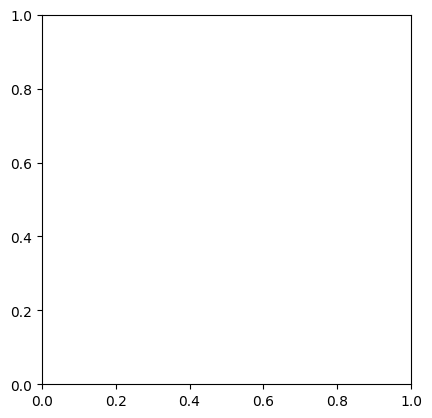

In [12]:
import matplotlib.pyplot as plt

# Assuming the array is a 2D numpy array
array = dsprites_dataset.get_data_by_label(ShapeType.SQUARE.value)[0][0]
plt.imshow(array, cmap='binary')
plt.show()

In [3]:
square_dataset = dsprites_dataset.get_data_by_label(ShapeType.SQUARE.value)
square_loader = DataLoader(square_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

circle_dataset = dsprites_dataset.get_data_by_label(ShapeType.CIRCLE.value)
circle_loader = DataLoader(circle_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

square_embeddings = torch.tensor([], device=device)
circle_embeddings = torch.tensor([], device=device)    


NameError: name 'dsprites_dataset' is not defined

In [ ]:
for idx, batch in enumerate(square_loader):
    inputs, _ = batch
    inputs = inputs.float().to(device)
    embedding, _ = model(inputs)
    square_embeddings = torch.cat((square_embeddings, embedding), dim=0)
    break

In [ ]:
square_embeddings.shape

In [36]:
torch.save(square_embeddings, 'embeddings/square_embeddings.pth')

In [40]:
for idx, batch in enumerate(circle_loader):
    inputs, _ = batch
    inputs = inputs.float().to(device)
    embedding, _ = model(inputs)
    circle_embeddings = torch.cat((circle_embeddings, embedding), dim=0)
    break

In [ ]:
circle_embeddings.shape

In [42]:
torch.save(circle_embeddings, 'embeddings/circle_embeddings.pth')

### Model Training

In [1]:
import torch 

circle_embeddings = torch.load('embeddings/circle_embeddings.pth')
square_embeddings = torch.load('embeddings/square_embeddings.pth')

/var/folders/bl/kzfk5ts90gj98y9jcv49ynmc0000gn/T/ipykernel_82023/726384858.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  circle_embeddings = torch.load('embeddings/cir

In [2]:
print(square_embeddings.shape)
print(circle_embeddings.shape)

torch.Size([128, 65, 192])
torch.Size([384, 65, 192])
